# NCAA 2025 Prediction Simulation 


# SYSTEM ARCHITECTURE
## 1. Data Ingestion

In this first phase, we load all relevant datasets from Kaggle, including:
- Regular season results
- Tournament results
- Team seeds
- Team metadata

We will filter the data for seasons from 2015 onward, and extract key values such as the numeric part of each team's seed.

In [26]:
import pandas as pd
import os

DATA_PATH = "Data/"
PREDICTIONS_PATH = "Predictions/"
os.makedirs(PREDICTIONS_PATH, exist_ok=True)

# Load tournament seeds
seeds_m = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
seeds_m["Gender"] = "M"
seeds_w = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
seeds_w["Gender"] = "W"
seeds = pd.concat([seeds_m, seeds_w], ignore_index=True)

# Load tournament results
results_m = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
results_m["Gender"] = "M"
results_w = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
results_w["Gender"] = "W"
tourney_results = pd.concat([results_m, results_w], ignore_index=True)

# Load regular season stats
season_m = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
season_m["Gender"] = "M"
season_w = pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
season_w["Gender"] = "W"
season_stats = pd.concat([season_m, season_w], ignore_index=True)

# Load team names
teams_m = pd.read_csv(DATA_PATH + "MTeams.csv")
teams_m["Gender"] = "M"
teams_w = pd.read_csv(DATA_PATH + "WTeams.csv")
teams_w["Gender"] = "W"
teams = pd.concat([teams_m, teams_w], ignore_index=True)

# Load season info
seasons_m = pd.read_csv(DATA_PATH + "MSeasons.csv")
seasons_m["Gender"] = "M"
seasons_w = pd.read_csv(DATA_PATH + "WSeasons.csv")
seasons_w["Gender"] = "W"
seasons = pd.concat([seasons_m, seasons_w], ignore_index=True)

# Sample submission
submission = pd.read_csv(DATA_PATH + "SampleSubmissionStage1.csv")

# Confirm shapes
print("-> Seeds:", seeds.shape)
print("-> Tourney results:", tourney_results.shape)
print("-> Regular season stats:", season_stats.shape)
print("-> Teams:", teams.shape)
print("-> Seasons:", seasons.shape)


-> Seeds: (4370, 4)
-> Tourney results: (4168, 9)
-> Regular season stats: (200590, 35)
-> Teams: (758, 5)
-> Seasons: (69, 7)


## 2. Data Reprocessing
### Filter datasets to include only seasons from 2015 onward

We restrict the analysis to data from 2015 and later to ensure consistency and relevance. This filter is applied to the regular season games, tournament results, and seed information.


In [27]:
# Regular Season
print("📊 Regular Season Stats (before):", season_stats.shape)
print("Seasons (before):", sorted(season_stats["Season"].unique()))

season_stats = season_stats[season_stats["Season"] >= 2015]

print("✅ Regular Season Stats (after):", season_stats.shape)
print("Seasons (after):", sorted(season_stats["Season"].unique()))

# Tournament Results
print("\n📊 Tournament Results (before):", tourney_results.shape)
print("Seasons (before):", sorted(tourney_results["Season"].unique()))

tourney_results = tourney_results[tourney_results["Season"] >= 2015]

print("✅ Tournament Results (after):", tourney_results.shape)
print("Seasons (after):", sorted(tourney_results["Season"].unique()))

# Seeds
print("\n📊 Seeds (before):", seeds.shape)
print("Seasons (before):", sorted(seeds["Season"].unique()))

seeds = seeds[seeds["Season"] >= 2015]

print("✅ Seeds (after):", seeds.shape)
print("Seasons (after):", sorted(seeds["Season"].unique()))


📊 Regular Season Stats (before): (200590, 35)
Seasons (before): [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
✅ Regular Season Stats (after): (114465, 35)
Seasons (after): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

📊 Tournament Results (before): (4168, 9)
Seasons (before): [np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(20

### Process team seeds and extract numeric values

Each team in the NCAA tournament is assigned a "seed" (e.g., 'W05', 'X12b') representing its rank within a region.
To use this as a numeric feature, we extract only the numeric part of the seed (e.g., 'W05' → 5).

This will later allow us to compute the seed difference between two teams.


In [28]:
import re

# Extract numeric part from seed (e.g., 'W05a' → 5)
def extract_seed_number(seed_str):
    match = re.search(r'\d+', seed_str)
    return int(match.group()) if match else None

# Apply to full dataset (masculino + femenino)
seeds["SeedNum"] = seeds["Seed"].apply(extract_seed_number)

# Preview result
print("✅ Numeric seed extracted:")
print(seeds[["Season", "TeamID", "Gender", "Seed", "SeedNum"]].head())


✅ Numeric seed extracted:
      Season  TeamID Gender Seed  SeedNum
1946    2015    1437      M  W01        1
1947    2015    1438      M  W02        2
1948    2015    1328      M  W03        3
1949    2015    1257      M  W04        4
1950    2015    1320      M  W05        5


## 3. Feature Engineering
### Compute seed difference for each tournament game

We now join the seed values to both teams in each game from the NCAA tournament historical results.

The seed difference (SeedB - SeedA) will be one of the key features used for prediction.


In [29]:
# Rename seed dataframe to merge easily for winners and losers
seeds_A = seeds.rename(columns={"TeamID": "WTeamID", "SeedNum": "SeedA"})
seeds_B = seeds.rename(columns={"TeamID": "LTeamID", "SeedNum": "SeedB"})

# Merge seeds with tournament results (by Season, Gender and TeamID)
tourney_seeds = pd.merge(
    tourney_results,
    seeds_A[["Season", "Gender", "WTeamID", "SeedA"]],
    on=["Season", "Gender", "WTeamID"],
    how="left"
)

tourney_seeds = pd.merge(
    tourney_seeds,
    seeds_B[["Season", "Gender", "LTeamID", "SeedB"]],
    on=["Season", "Gender", "LTeamID"],
    how="left"
)

# Calculate seed difference: TeamB - TeamA
tourney_seeds["SeedDiff"] = tourney_seeds["SeedB"] - tourney_seeds["SeedA"]

# Preview the result
print("✅ SeedDiff calculated:")
tourney_seeds[["Season", "Gender", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"]].head()


✅ SeedDiff calculated:


,Season,Gender,WTeamID,LTeamID,SeedA,SeedB,SeedDiff
0,2015,M,1214,1264,16,16,0
1,2015,M,1279,1140,11,11,0
2,2015,M,1173,1129,11,11,0
3,2015,M,1352,1316,16,16,0
4,2015,M,1112,1411,2,15,13


### Team-Level Statistics

In addition to calculating the seed difference (SeedDiff), we now generate statistical features based on each team’s performance during the regular season. These features are computed separately for each team, season, and gender, and will later be merged into the tournament matchups dataset.

The statistics include:

- Win-loss ratio (WinLossRatio)
- Average points scored and allowed per game
- Total points scored and allowed
- Scoring margin (average point differential)

This information will provide richer context about each team's historical performance and is expected to improve prediction accuracy when combined with tournament seed information.


In [30]:
# Stats for winning teams
w_stats = season_stats[["Season", "Gender", "WTeamID", "WScore", "LScore"]].copy()
w_stats["Win"] = 1
w_stats.rename(columns={
    "WTeamID": "TeamID",
    "WScore": "PointsScored",
    "LScore": "PointsAllowed"
}, inplace=True)

# Stats for losing teams
l_stats = season_stats[["Season", "Gender", "LTeamID", "LScore", "WScore"]].copy()
l_stats["Win"] = 0
l_stats.rename(columns={
    "LTeamID": "TeamID",
    "LScore": "PointsScored",
    "WScore": "PointsAllowed"
}, inplace=True)

# Combine all match results (wins + losses)
all_stats = pd.concat([w_stats, l_stats], ignore_index=True)

# Aggregate stats per team, season and gender
team_stats = all_stats.groupby(["Season", "Gender", "TeamID"]).agg(
    GamesPlayed=("Win", "count"),
    Wins=("Win", "sum"),
    AvgPointsScored=("PointsScored", "mean"),
    AvgPointsAllowed=("PointsAllowed", "mean"),
    TotalPointsScored=("PointsScored", "sum"),
    TotalPointsAllowed=("PointsAllowed", "sum")
).reset_index()

# Derived metrics
team_stats["WinLossRatio"] = team_stats["Wins"] / team_stats["GamesPlayed"]
team_stats["ScoringMargin"] = team_stats["AvgPointsScored"] - team_stats["AvgPointsAllowed"]

# Preview
print("✅ Team statistics generated:")

print(team_stats.columns.tolist())
team_stats.head()

✅ Team statistics generated:
['Season', 'Gender', 'TeamID', 'GamesPlayed', 'Wins', 'AvgPointsScored', 'AvgPointsAllowed', 'TotalPointsScored', 'TotalPointsAllowed', 'WinLossRatio', 'ScoringMargin']


,Season,Gender,TeamID,GamesPlayed,Wins,AvgPointsScored,AvgPointsAllowed,TotalPointsScored,TotalPointsAllowed,WinLossRatio,ScoringMargin
0,2015,M,1101,28,7,61.000000,71.857143,1708,2012,0.250000,-10.857143
1,2015,M,1102,29,12,64.724138,65.862069,1877,1910,0.413793,-1.137931
2,2015,M,1103,34,20,67.352941,63.235294,2290,2150,0.588235,4.117647
3,2015,M,1104,31,17,66.645161,64.516129,2066,2000,0.548387,2.129032
4,2015,M,1105,28,8,61.285714,68.714286,1716,1924,0.285714,-7.428571


### Merging Team Statistics into Matchups

After calculating per-team statistics from the regular season, we now enrich the tournament matchups dataset by merging those stats for both Team A (winner) and Team B (loser) in each historical game.

For each matchup, we include:

- Win-loss ratio (for both teams)
- Average points scored and allowed
- Scoring margin

In addition, we compute derived features that capture the difference in performance between the two teams, such as:

- Difference in win-loss ratio
- Difference in scoring margin
- Difference in average points scored

These comparative features are particularly useful for training classification models that predict the outcome of matchups based on historical strength indicators.


In [31]:
import os
import pandas as pd

# Clean tourney_seeds to retain only the necessary base columns
tourney_seeds = tourney_seeds[[
    "Season", "Gender", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"
]].copy()

# STEP 1 — Keep only relevant columns from team_stats
team_stats_clean = team_stats[[
    "Season", "Gender", "TeamID",
    "WinLossRatio", "AvgPointsScored", "AvgPointsAllowed", "ScoringMargin"
]]

# STEP 2 — Merge team stats for WTeamID (Team A)
tourney_seeds = pd.merge(
    tourney_seeds,
    team_stats_clean,
    left_on=["Season", "Gender", "WTeamID"],
    right_on=["Season", "Gender", "TeamID"],
    how="left"
).rename(columns={
    "WinLossRatio": "W_WinLoss",
    "AvgPointsScored": "W_PPG",
    "AvgPointsAllowed": "W_PtsAllowed",
    "ScoringMargin": "W_Margin"
}).drop(columns=["TeamID"])

# STEP 3 — Merge team stats for LTeamID (Team B)
tourney_seeds = pd.merge(
    tourney_seeds,
    team_stats_clean,
    left_on=["Season", "Gender", "LTeamID"],
    right_on=["Season", "Gender", "TeamID"],
    how="left"
).rename(columns={
    "WinLossRatio": "L_WinLoss",
    "AvgPointsScored": "L_PPG",
    "AvgPointsAllowed": "L_PtsAllowed",
    "ScoringMargin": "L_Margin"
}).drop(columns=["TeamID"])

# STEP 4 — Clean any duplicate columns (just in case)
tourney_seeds = tourney_seeds.loc[:, ~tourney_seeds.columns.duplicated()]

# STEP 5 — Compute difference features safely
tourney_seeds["Diff_WinLoss"] = tourney_seeds["W_WinLoss"] - tourney_seeds["L_WinLoss"]
tourney_seeds["Diff_Margin"] = tourney_seeds["W_Margin"] - tourney_seeds["L_Margin"]
tourney_seeds["Diff_PPG"] = tourney_seeds["W_PPG"] - tourney_seeds["L_PPG"]
tourney_seeds["Diff_PtsAllowed"] = tourney_seeds["W_PtsAllowed"] - tourney_seeds["L_PtsAllowed"]

# STEP 6 — Export the final dataset
os.makedirs("Features", exist_ok=True)
tourney_seeds.to_csv("Features/full_feature_dataset.csv", index=False)
print("✅ Feature-enriched dataset exported to: Features/full_feature_dataset.csv")

#preview
print("📋 Final column list:")
print(tourney_seeds.columns.tolist())
tourney_seeds.head()


✅ Feature-enriched dataset exported to: Features/full_feature_dataset.csv
📋 Final column list:
['Season', 'Gender', 'WTeamID', 'LTeamID', 'SeedA', 'SeedB', 'SeedDiff', 'W_WinLoss', 'W_PPG', 'W_PtsAllowed', 'W_Margin', 'L_WinLoss', 'L_PPG', 'L_PtsAllowed', 'L_Margin', 'Diff_WinLoss', 'Diff_Margin', 'Diff_PPG', 'Diff_PtsAllowed']


,Season,Gender,WTeamID,LTeamID,SeedA,SeedB,SeedDiff,W_WinLoss,W_PPG,W_PtsAllowed,W_Margin,L_WinLoss,L_PPG,L_PtsAllowed,L_Margin,Diff_WinLoss,Diff_Margin,Diff_PPG,Diff_PtsAllowed
0,2015,M,1214,1264,16,16,0,0.484848,67.151515,68.000000,-0.848485,0.593750,69.875000,67.500000,2.375000,-0.108902,-3.223485,-2.723485,0.500000
1,2015,M,1279,1140,11,11,0,0.625000,72.625000,67.500000,5.125000,0.718750,81.843750,72.937500,8.906250,-0.093750,-3.781250,-9.218750,-5.437500
2,2015,M,1173,1129,11,11,0,0.757576,68.212121,60.909091,7.303030,0.741935,69.870968,60.935484,8.935484,0.015640,-1.632454,-1.658847,-0.026393
3,2015,M,1352,1316,16,16,0,0.575758,69.000000,67.727273,1.272727,0.645161,73.935484,68.516129,5.419355,-0.069404,-4.146628,-4.935484,-0.788856
4,2015,M,1112,1411,2,15,13,0.911765,76.441176,58.617647,17.823529,0.647059,68.176471,67.441176,0.735294,0.264706,17.088235,8.264706,-8.823529


### Create a neutral matchup dataset for training

To train a predictive model, we restructure each historical game into a matchup between TeamA and TeamB, and assign a binary target variable `Winner`.

For balance, each game is represented twice:
- Once with the winning team as TeamA (`Winner = 1`)
- Once with the losing team as TeamA (`Winner = 0`)


In [32]:
# 🔍 First, confirm expected columns exist
required_cols = [
    "W_WinLoss", "L_WinLoss", "W_Margin", "L_Margin",
    "W_PPG", "L_PPG", "W_PtsAllowed", "L_PtsAllowed",
    "SeedA", "SeedB", "WTeamID", "LTeamID"
]

missing_cols = [col for col in required_cols if col not in tourney_seeds.columns]
if missing_cols:
    raise ValueError(f"❌ Missing required columns in tourney_seeds: {missing_cols}")

# ✅ First version: TeamA is the winner
df_win = tourney_seeds.copy()
df_win["TeamA"] = df_win["WTeamID"]
df_win["TeamB"] = df_win["LTeamID"]
df_win["Winner"] = 1
df_win["SeedDiff"] = df_win["SeedB"] - df_win["SeedA"]
df_win["WinLossDiff"] = df_win["W_WinLoss"] - df_win["L_WinLoss"]
df_win["MarginDiff"] = df_win["W_Margin"] - df_win["L_Margin"]
df_win["PPGDiff"] = df_win["W_PPG"] - df_win["L_PPG"]
df_win["PtsAllowedDiff"] = df_win["W_PtsAllowed"] - df_win["L_PtsAllowed"]

# 🔁 Second version: TeamA is the loser
df_lose = tourney_seeds.copy()
df_lose["TeamA"] = df_lose["LTeamID"]
df_lose["TeamB"] = df_lose["WTeamID"]
df_lose["Winner"] = 0
df_lose["SeedDiff"] = df_lose["SeedA"] - df_lose["SeedB"]
df_lose["WinLossDiff"] = df_lose["L_WinLoss"] - df_lose["W_WinLoss"]
df_lose["MarginDiff"] = df_lose["L_Margin"] - df_lose["W_Margin"]
df_lose["PPGDiff"] = df_lose["L_PPG"] - df_lose["W_PPG"]
df_lose["PtsAllowedDiff"] = df_lose["L_PtsAllowed"] - df_lose["W_PtsAllowed"]

# 📦 Combine both into a balanced dataset
matchups = pd.concat([df_win, df_lose], ignore_index=True)

# 🧼 Select only relevant columns
matchups = matchups[[
    "Season", "Gender", "TeamA", "TeamB",
    "SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff", "Winner"
]]

# export to CSV
matchups.to_csv("Features/balanced_matchups.csv", index=False)
print("✅ Matchups exported to: Features/balanced_matchups.csv")

# 🔍 Preview
matchups.head()


✅ Matchups exported to: Features/balanced_matchups.csv


,Season,Gender,TeamA,TeamB,SeedDiff,WinLossDiff,MarginDiff,PPGDiff,PtsAllowedDiff,Winner
0,2015,M,1214,1264,0,-0.108902,-3.223485,-2.723485,0.500000,1
1,2015,M,1279,1140,0,-0.093750,-3.781250,-9.218750,-5.437500,1
2,2015,M,1173,1129,0,0.015640,-1.632454,-1.658847,-0.026393,1
3,2015,M,1352,1316,0,-0.069404,-4.146628,-4.935484,-0.788856,1
4,2015,M,1112,1411,13,0.264706,17.088235,8.264706,-8.823529,1


## 4. Prediction Engine
### Train a prediction model (Logistic Regression)

We will now train a logistic regression model using historical NCAA tournament games. The model will learn to estimate the probability that TeamA wins based on the seed difference.


✅ Logistic Regression model trained
📊 Accuracy: 0.7505
📈 AUC Score: 0.8157


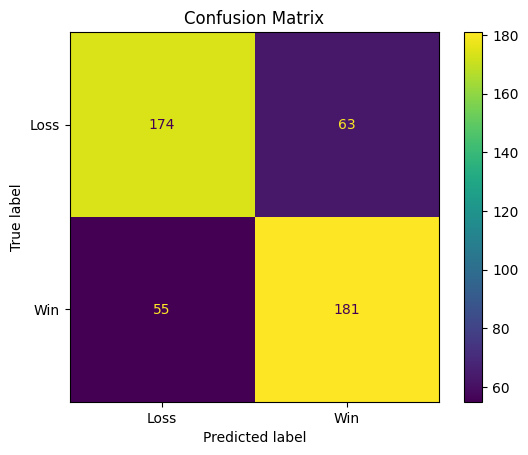

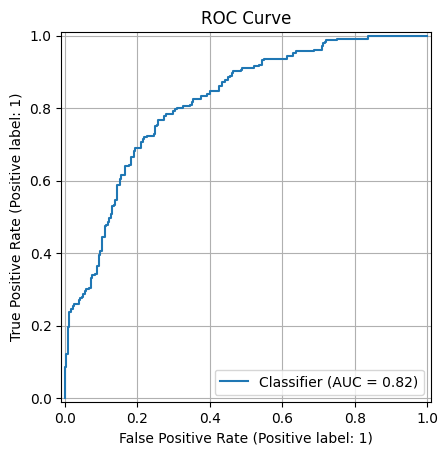

In [33]:
# ✅ Logistic Regression using multiple features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Select input features and target
features = ["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]
X = matchups[features]
y = matchups["Winner"]

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("✅ Logistic Regression model trained")
print(f"📊 Accuracy: {accuracy:.4f}")
print(f"📈 AUC Score: {auc:.4f}")

# 5. Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Loss", "Win"])
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 6. Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.grid(True)
plt.show()


# Scenarios
## Baseline Scenario: Predicting NCAA 2025 Matchups

In this experiment, we simulate all possible matchups for the NCAA 2025 tournament using the previously trained logistic regression model. Each pair of qualified teams is evaluated twice (once as TeamA vs TeamB, and once mirrored as TeamB vs TeamA) to ensure symmetric prediction coverage.

For every matchup, the following engineered features are computed as input:
- `SeedDiff`: Difference in tournament seed (TeamB − TeamA)
- `WinLossDiff`: Difference in win-loss ratios between teams
- `MarginDiff`: Difference in average scoring margin
- `PPGDiff`: Difference in average points scored per game
- `PtsAllowedDiff`: Difference in average points allowed

Using these inputs, the model estimates the probability that TeamA will win each hypothetical game. These predictions represent the system’s output under ideal (non-perturbed) input conditions and serve as the baseline for comparison against other simulation scenarios.



In [52]:
from itertools import combinations
import numpy as np
import pandas as pd

# 1. Filter teams that qualified for the 2025 tournament
seeds_2025 = seeds[seeds["Season"] == 2025][["TeamID", "SeedNum", "Gender"]].copy()
team_stats_2025 = team_stats[team_stats["Season"] == 2025].copy()

# 2. Generate all possible matchups (TeamA ≠ TeamB)
baseline_rows = []
for gender in seeds_2025["Gender"].unique():
    teams = seeds_2025[seeds_2025["Gender"] == gender]["TeamID"].unique()

    for teamA, teamB in combinations(teams, 2):
        # Retrieve seed values
        sA = seeds_2025[(seeds_2025["TeamID"] == teamA) & (seeds_2025["Gender"] == gender)]["SeedNum"].values[0]
        sB = seeds_2025[(seeds_2025["TeamID"] == teamB) & (seeds_2025["Gender"] == gender)]["SeedNum"].values[0]

        # Retrieve team stats
        statsA = team_stats_2025[(team_stats_2025["TeamID"] == teamA) & (team_stats_2025["Gender"] == gender)]
        statsB = team_stats_2025[(team_stats_2025["TeamID"] == teamB) & (team_stats_2025["Gender"] == gender)]

        if statsA.empty or statsB.empty:
            continue  # Skip if data is missing

        # Compute input features
        row = {
            "Season": 2025,
            "Gender": gender,
            "TeamA": teamA,
            "TeamB": teamB,
            "SeedDiff": sB - sA,
            "WinLossDiff": statsA["WinLossRatio"].values[0] - statsB["WinLossRatio"].values[0],
            "MarginDiff": statsA["ScoringMargin"].values[0] - statsB["ScoringMargin"].values[0],
            "PPGDiff": statsA["AvgPointsScored"].values[0] - statsB["AvgPointsScored"].values[0],
            "PtsAllowedDiff": statsA["AvgPointsAllowed"].values[0] - statsB["AvgPointsAllowed"].values[0],
        }

        # Mirror the matchup (TeamB vs TeamA)
        row_mirror = row.copy()
        row_mirror["TeamA"] = teamB
        row_mirror["TeamB"] = teamA
        row_mirror["SeedDiff"] *= -1
        row_mirror["WinLossDiff"] *= -1
        row_mirror["MarginDiff"] *= -1
        row_mirror["PPGDiff"] *= -1
        row_mirror["PtsAllowedDiff"] *= -1

        baseline_rows.extend([row, row_mirror])

# 3. Create DataFrame with all matchups
baseline_df = pd.DataFrame(baseline_rows)

# 4. Predict win probabilities using the trained model
features = ["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]
baseline_df["Pred"] = model.predict_proba(baseline_df[features])[:, 1]


print("🔢 Total matchups:", len(baseline_df))



# Load the baseline predictions for 2025 (adjust path if needed)
baseline_df["Season"] = 2025

# Create ID in Kaggle format: Season_TeamA_TeamB
baseline_df["ID"] = baseline_df["Season"].astype(str) + "_" + \
                    baseline_df["TeamA"].astype(str) + "_" + \
                    baseline_df["TeamB"].astype(str)


if "Pred" not in baseline_df.columns and "Prediction" in baseline_df.columns:
    baseline_df.rename(columns={"Prediction": "Pred"}, inplace=True)

submission_df = baseline_df[["ID", "Pred"]]

# Save to CSV
submission_df.to_csv("Predictions/baseline_scenario.csv", index=False)
print("✅ Submission file saved to: Predictions/baseline_scenario.csv")

baseline_df.head()

🔢 Total matchups: 9112
✅ Submission file saved to: Predictions/baseline_scenario.csv


,Season,Gender,TeamA,TeamB,SeedDiff,WinLossDiff,MarginDiff,PPGDiff,PtsAllowedDiff,Pred,ID
0,2025,M,1181,1104,1,0.154189,11.097148,-8.415330,-19.512478,0.699617,2025_1181_1104
1,2025,M,1104,1181,-1,-0.154189,-11.097148,8.415330,19.512478,0.303070,2025_1104_1181
2,2025,M,1181,1458,2,0.168908,11.508403,2.991597,-8.516807,0.728974,2025_1181_1458
3,2025,M,1458,1181,-2,-0.168908,-11.508403,-2.991597,8.516807,0.273553,2025_1458_1181
4,2025,M,1181,1112,3,0.264706,11.500000,0.970588,-10.529412,0.727022,2025_1181_1112


## Perturbed Scenario: Sensitivity to Input Noise

To evaluate the system’s robustness, we simulate uncertainty in the input data by introducing small perturbations to the feature SeedDiff.

Specifically, we apply a random variation between ±2% and ±5% of the absolute value of each matchup’s SeedDiff. All other features remain unchanged. The goal is to observe how sensitive the model is to small changes in the input and whether such noise significantly affects prediction outcomes.

After perturbing SeedDiff, we reapply the trained logistic regression model and compare the new predictions to the baseline. These results help us assess the stability and reliability of the predictive system under real-world uncertainty.


In [49]:
import numpy as np

# Copy the baseline predictions
perturbed_df = baseline_df.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Generate noise between ±2% and ±5% of absolute SeedDiff
perturbation_pct = np.random.uniform(0.02, 0.05, size=len(perturbed_df))
perturbation_sign = np.random.choice([-1, 1], size=len(perturbed_df))
perturbation = perturbation_pct * perturbed_df["SeedDiff"].abs() * perturbation_sign

# Store original for comparison
perturbed_df["PerturbedSeedDiff"] = perturbed_df["SeedDiff"] + perturbation

# Replace only SeedDiff used for prediction
X_perturbed = perturbed_df[["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]].copy()
X_perturbed["SeedDiff"] = perturbed_df["PerturbedSeedDiff"]

# Predict again
perturbed_df["PerturbedPred"] = model.predict_proba(X_perturbed)[:, 1]

# Load the baseline predictions for 2025 (adjust path if needed)
perturbed_df["Season"] = 2025

# Create ID in Kaggle format: Season_TeamA_TeamB
perturbed_df["ID"] = baseline_df["Season"].astype(str) + "_" + \
                    baseline_df["TeamA"].astype(str) + "_" + \
                    baseline_df["TeamB"].astype(str)


if "Pred" not in perturbed_df.columns and "Prediction" in perturbed_df.columns:
    perturbed_df.rename(columns={"Prediction": "Pred"}, inplace=True)

submission_dff = perturbed_df[["ID", "Pred"]]

# Save to CSV
submission_dff.to_csv("Predictions/perturbed_scenario.csv", index=False)
print("✅ Submission file saved to: Predictions/perturbed_scenario.csv")

✅ Submission file saved to: Predictions/perturbed_scenario.csv


###  Prediction Shift Analysis

This section analyzes how sensitive the model's predictions are to small perturbations in the input feature (SeedDiff). To simulate real-world data uncertainty, random noise between ±2% and ±5% was added to the original SeedDiff values for each 2025 tournament matchup.

Two key metrics are reported to evaluate the system’s robustness:

-  Average Change: The mean absolute difference between the baseline and perturbed predicted probabilities.
-  Shift Proportion: The percentage of matchups where the prediction changed by more than ±0.10.

The following scatter plot helps visualize prediction stability:
- Each dot corresponds to a matchup.
- The red dashed line (y = x) represents perfect consistency between baseline and perturbed predictions.
- Points further from the diagonal indicate higher sensitivity to noise in the input.

This analysis allows us to quantify the resilience of the predictive engine when faced with input-level variations, offering insights into the reliability of the model under uncertain or imperfect data conditions.


📈 Average change in prediction: 0.0042
⚠️  Matchups with >±0.10 change: 0.00%


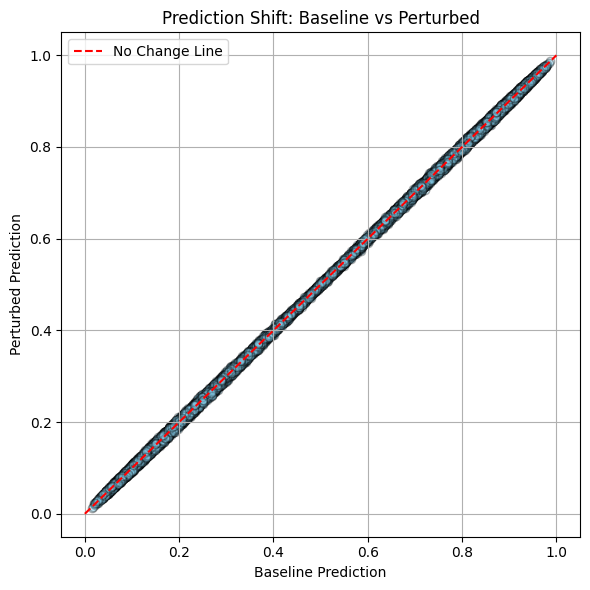

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure these two DataFrames exist with the correct columns:
# baseline_df: contains TeamA, TeamB, Pred
# perturbed_df: contains TeamA, TeamB, PerturbedPred

# Combine baseline and perturbed predictions
comparison_df = baseline_df[["TeamA", "TeamB", "Pred"]].copy()
comparison_df["PerturbedPred"] = perturbed_df["PerturbedPred"]

#  Compute absolute differences
comparison_df["Delta"] = comparison_df["PerturbedPred"] - comparison_df["Pred"]
comparison_df["AbsDelta"] = comparison_df["Delta"].abs()

#  Compute key metrics
avg_change = comparison_df["AbsDelta"].mean()
shift_pct = (comparison_df["AbsDelta"] > 0.10).mean() * 100

print(f"📈 Average change in prediction: {avg_change:.4f}")
print(f"⚠️  Matchups with >±0.10 change: {shift_pct:.2f}%")

# 📈 Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(comparison_df["Pred"], comparison_df["PerturbedPred"], alpha=0.3, color="skyblue", edgecolors="k")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="No Change Line")
plt.xlabel("Baseline Prediction")
plt.ylabel("Perturbed Prediction")
plt.title("Prediction Shift: Baseline vs Perturbed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Predictions/prediction_shift_plot.png", dpi=300)
plt.show()

#  Save comparison table
comparison_df.to_csv("Predictions/prediction_shift_table.csv", index=False)


## Perturbed Scenario (Multi-Feature)

In this simulation, we introduce controlled perturbations to multiple input features to evaluate the robustness and sensitivity of the predictive model under uncertain or noisy conditions.

Specifically, the following input features are affected:

- `SeedDiff`: Difference in seed rankings
- `WinLossDiff`: Difference in win/loss ratio between teams
- `MarginDiff`: Difference in average scoring margin
- `PPGDiff`: Difference in average points per game
- `PtsAllowedDiff`: Difference in average points allowed

For each of these features, we add random noise ranging between ±2% and ±5% of the absolute value of the feature. This simulates realistic data fluctuations due to measurement errors or unexpected inputs.

After applying the perturbations, we reapply the trained logistic regression model to the modified data. 

In [55]:
import numpy as np
import pandas as pd

# Make a copy of your 2025 baseline predictions DataFrame
multi_perturbed_df = baseline_df.copy()

# Define the list of features to perturb
features_to_perturb = ["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]

# Apply noise to each feature
np.random.seed(42)  # for reproducibility
for feature in features_to_perturb:
    pct = np.random.uniform(0.02, 0.05, size=len(multi_perturbed_df))  # 2% to 5%
    sign = np.random.choice([-1, 1], size=len(multi_perturbed_df))     # direction
    noise = pct * multi_perturbed_df[feature].abs() * sign             # scaled noise
    multi_perturbed_df[f"Perturbed_{feature}"] = multi_perturbed_df[feature] + noise

# Create a new input DataFrame for prediction
X_perturbed = multi_perturbed_df[[f"Perturbed_{f}" for f in features_to_perturb]].copy()
X_perturbed.columns = features_to_perturb  # rename back to original for model

# Predict using the perturbed inputs
multi_perturbed_df["PerturbedPred"] = model.predict_proba(X_perturbed)[:, 1]

# Format for Kaggle submission
multi_perturbed_df["Season"] = 2025
multi_perturbed_df["ID"] = multi_perturbed_df["Season"].astype(str) + "_" + \
                           multi_perturbed_df["TeamA"].astype(str) + "_" + \
                           multi_perturbed_df["TeamB"].astype(str)

# Prepare submission format
submission_df = multi_perturbed_df[["ID", "PerturbedPred"]].rename(columns={"PerturbedPred": "Pred"})

# Save to CSV
submission_df.to_csv("Predictions/perturbed_multi_feature_scenario.csv", index=False)
print("✅ Multi-feature perturbation saved to: Predictions/perturbed_multi_feature_scenario.csv")


✅ Multi-feature perturbation saved to: Predictions/perturbed_multi_feature_scenario.csv


📈 Average change in prediction: 0.0050
⚠️  Matchups with >±0.10 change: 0.00%


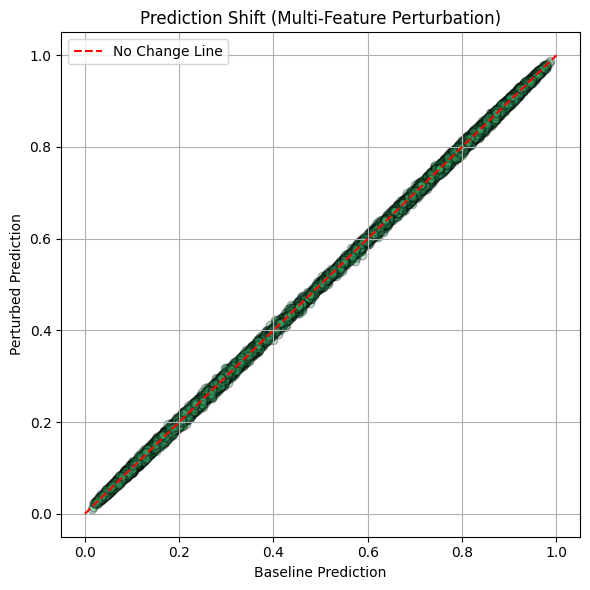

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Create comparison DataFrame
comparison_df = baseline_df[["TeamA", "TeamB", "Pred"]].copy()
comparison_df["PerturbedPred"] = multi_perturbed_df["PerturbedPred"]

# Compute absolute differences
comparison_df["Delta"] = comparison_df["PerturbedPred"] - comparison_df["Pred"]
comparison_df["AbsDelta"] = comparison_df["Delta"].abs()

# Compute metrics
avg_change = comparison_df["AbsDelta"].mean()
shift_pct = (comparison_df["AbsDelta"] > 0.10).mean() * 100

print(f"📈 Average change in prediction: {avg_change:.4f}")
print(f"⚠️  Matchups with >±0.10 change: {shift_pct:.2f}%")

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(comparison_df["Pred"], comparison_df["PerturbedPred"], alpha=0.3, color="mediumseagreen", edgecolors="k")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="No Change Line")
plt.xlabel("Baseline Prediction")
plt.ylabel("Perturbed Prediction")
plt.title("Prediction Shift (Multi-Feature Perturbation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Predictions/prediction_shift_multi_feature.png", dpi=300)
plt.show()

# Save comparison table
comparison_df.to_csv("Predictions/prediction_shift_multi_feature_table.csv", index=False)
